### Abstract

In our project, we sought to predict whether umpires will call a pitch correctly or not. We used features of the pitch like its velocity and release position and features of the game situation like number of runners on base, pitch count, and inning to train a logistic regression model. We chose these features because we wanted to look for patterns in pitch calls that weren't related to where the pitch ended up over the plate. We fit a logistic regression model that achieved around 65% accuracy in predicting whether umpires would make the correct call. We also developed a custom Newton-based model, which showed promising sensitivity to borderline pitches but ultimately struggled to converge. Across both models, we observed a consistent bias: predictions were significantly more accurate for right-handed batters than for left-handed ones. This disparity points to potential asymmetries in umpire behavior and highlights an important direction for future analysis. 


[Find the source code here](https://github.com/ctkatz/ML_project)

### Introduction

The problem that we want to address in the project is improving fairness in baseball. We want to see if we can detect patterns in incorrect calls to highlight bias towards or against certain 
player demographics, game situations, or pitch types. This information could help teams understand when pitchers need to be more precise with their pitch locations and help umpires focus on calling pitches extra carefully during situations when they have been found to be less consistent. We hypothesize that there may be other factors impacting an umpires' decision to call a strike besides just the location of the pitch when it arrives over the plate. 

Statistics are an essential part of modern day baseball, and all MLB teams have extensive infrastructure in data analytics. Furthermore, because the MLB statistics are publicly available, there are many people using statistical and machine learning methods to make predictions about baseball pitches. Specifically, there has been a lot of work in using classification methods to predict pitch types. Glenn Sidle and Hien Tran, for example, used different multi-class classification methods to predict pitch types (@predictpitchtypes). They used post-processing techniques, like ranking the permuted variable delta error of each feature that was calculated in the construction of their random forest, to investigate the importance of each of the features they used. They found pitch count and batter handedness to be some of the most important features. Even though they were asking a different question than we are, it was still useful to see which features impact the pitch type the most, because these features could also impact the umpire calling the pitch. Or, if if pitch type impacts call correctness, these features would also be important. Additionally, they used categorical features like number of outs, inning, score, and time of day in their model, which helped us figure out how we might also want to use features like these in our model. 

In another paper that we looked at, Jasmine Barbee was predicting the final pitch outcome for an at-bat (@predictfinaloutcome). That is, whether the last pitch of the at bat was a strike (strikeout), a ball (walk), put in play but an out, or a hit. Barbee did some exploration into features like pitch speed and she was able to predict with reasonable accuracy the outcome of the final pitch using the pitch count, the horizontal and vertical pitch locations, and the start and end speeds of the pitch. Her process highlighted how these features can be used in conjunction with each other to learn information about a pitch without knowing its position over the plate. When we decided which features to use for our model, we used insights we had gained from other peoples' work in classifying pitches. 

Futhermore, we also looked at some work that was aiming to answer a question similar to the one that we are. Etan Green and David Daniels at Stanford found that when the pitch count is 3-0 the strike zone expands, and when the pitch count is 0-2, the strike zone contracts (@umpirebias). We found these results to support our hypothesis that umpires might not call strikes based soley on the location of the pitch, there may be other factors at play. This paper also prompted us to include the pitch count as a feature in our model. We found that most of these papers, even if they didn't have the exact same research question that we did, mentioned similar motivations in their work that we have: making the game more fair and helping teams optimize their pitching capabilities to put them in a better position in a game.   


### Values Statement

This project would potentially be used by MLB teams and umpires. These teams are probably interested in understanding patterns in when pitches are likely to be called incorrectly, and umpires might be interesting in improving their call accuracy with this technology. [include something about potential results of looking for racial bias maybe]. 


This model could help improve baseball by potentially helping umpires learn patterns in when they are calling pitches incorrectly and improving accuracy. It could benefit players and teams because they could gain a better understanding of situations when pitches are less likely to be called correctly. If they're aware of these situations, they can try to avoid them. 


But, the ability for a model to find these patterns could potentially take away jobs from umpires in the long run. Automatic ball strike systems (electronic systems that use the ball position to call pitches instead of umpires) are already being used in minor league baseball. If technology is able to detect that umpires call pitches incorrectly with regularity, this may support the argument to replace home plate umpires with machines. 


Personally, all of our group members are big baseball fans. One of our favorite things about the game is how important statistics have become in baseball and how much analytical work is done to improve teams' performances. We were all really excited about the opportunity to work with baseball statistics and we think that this technology could, in theory, make baseball more equitable. Even though this work isn't necessarily improving the world as a whole, a lot of people care about baseball and making the game more fair might improve teams and fans' experiences with the game. 

### Materials and Methods

#### Our Data
The data used in this project comes from Major League Baseball (MLB) pitch tracking data, which records information about pitches thrown during games. The data was collected from publicly available sources, specifically MLB’s official pitch tracking systems and data repositories. Each row in the dataset represents a single pitch thrown by a pitcher, including features such as pitch type, velocity, location, the batter's handedness (left or right), the umpire’s call (strike or ball), and whether the call was correct. The data also includes metadata about the game, the batter, and the pitcher. The dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/amandaaapoor/2021regularseasonmlbpitches), and was uploaded there by user Amandaaa Poor. 

We also scraped a dataset from the MLB statcast API that includes information about each player active during the 2021 season (see code below). This dataset included batter handedness, batter nationality, position, and other information about each batter in the pitches dataset. We merged with this dataset with the pitches dataset so that we would have information about the pitch and batter for each pitch in the dataset. 

The primary focus of the our analysis was to determine bias which affects whether the umpire will make the correct call on a pitch, with additional breakdowns by batter handedness (left vs. right) and call type (strikes vs balls). The data was processed to handle missing values, standardize features, and generate additional variables like whether a pitch was on the edge of the strike zone. One potential limitation of the data is its inherent bias due to how pitch tracking systems are calibrated in different ballparks, which may affect accuracy. Additionally, the data does not account for environmental variables (such as lighting conditions or weather) that may influence umpire decisions. Since only pitches that were not hit are included in the analysis, the model may not generalize well to situations where the batter makes contact.

In [1]:
#| code-fold: true
#| code-summary: "Code to pull data from the MLB API"

import statsapi
import pandas as pd

def get_team_ids():
    teams = statsapi.get('teams', {'sportId': 1})['teams']
    return [team['id'] for team in teams]

def get_players_from_team(team_id, season='2021'):
    roster = statsapi.get('team_roster', {'teamId': team_id, 'season': season})
    return roster['roster']

def get_player_info_flat(player_id):
    person = statsapi.get('person', {'personId': player_id})
    info = person['people'][0]

    return {
        'id': info.get('id'),
        'fullName': info.get('fullName'),
        'birthDate': info.get('birthDate'),
        'birthCountry': info.get('birthCountry'),
        'height': info.get('height'),
        'weight': info.get('weight'),
        'primaryPosition': info.get('primaryPosition', {}).get('abbreviation'),
        'batSide': info.get('batSide', {}).get('code'),
        'pitchHand': info.get('pitchHand', {}).get('code'),
        'debutDate': info.get('mlbDebutDate'),
        'active': info.get('active'),
    }

def get_all_players_df(season='2021'):
    team_ids = get_team_ids()
    player_data = []

    for team_id in team_ids:
        players = get_players_from_team(team_id, season)
        for player in players:
            player_id = player['person']['id']
            info = get_player_info_flat(player_id)
            player_data.append(info)

    df = pd.DataFrame(player_data)
    return df

df_players = get_all_players_df()
print(df_players.head())

We joined our two dataframes so that we would have information for each pitch about the demographics of the batter that received each pitch in the pitches dataframe.  

In [3]:
import pandas as pd

players = pd.read_csv("mlb_players_2021.csv") # Our dataset
pitches = pd.read_csv("regseason.csv") # Dataset from Kaggle
players.rename(columns={"id" : "batter","fullName" : "batter_fullName" , "birthCountry" : "batter_birthCountry"}, inplace=True)
full_df = pd.merge(pitches, players[["batter","batter_fullName","batSide", "batter_birthCountry"]], on="batter")

We added some features to the dataset and did some cleaning to make it easier for us to work with. 

In [4]:
# Remove the pitches that were fouled, in play, or swung at
not_hit = ["called_strike", "ball"]
pitches_not_hit = full_df[full_df['description'].isin(not_hit)].copy()

# Create features needed for our analysis
pitches_not_hit["strike_zone"] = pitches_not_hit["zone"] <= 9 # Determine if the pitch was actually in the zone

pitches_not_hit["called_correctly"] = (
    ((pitches_not_hit["zone"] <= 9) & (pitches_not_hit["type"] == "S")) | # Pitch is in the zone and is called a strike  
    ((pitches_not_hit["zone"] > 9) & (pitches_not_hit["type"] == "B"))    # Pitch is not in the zone and is called a ball
) 
pitches_not_hit["called_correctly"] = pitches_not_hit["called_correctly"].astype(int) # This will be are target variable -- whether the pitch was called "correctly"

One of the limitations of our dataset was that there was a large class imbalance, there were significantly more pitches called correctly than called incorrectly, which isn't necessarily a bad thing. It's good to see that most of the pitches in the MLB are being called correctly, but this might be challenging for our analysis. We talk about how we handled this in the approach section.

In [5]:
#| echo: false

print("Number of pitches called correctly:", len(pitches_not_hit[pitches_not_hit["called_correctly"] == 1]))

Number of pitches called correctly: 357779


In [6]:


print("Number of pitches called incorrectly:",len(pitches_not_hit[pitches_not_hit["called_correctly"] == 0]))

Number of pitches called incorrectly: 32509


We made some initial visualizations of the data to get an understanding of what we are looking for. The colored area is the strike zone. We are looking to predict when pitches that are in the strike zone are called balls or when pitches that aren't in the strike zone are called strikes. The plot on the right shows us that these incorrectly called pitches are most likely to be near the edge of the strike zone, which makes sense; these pitches are the hardest to call! 

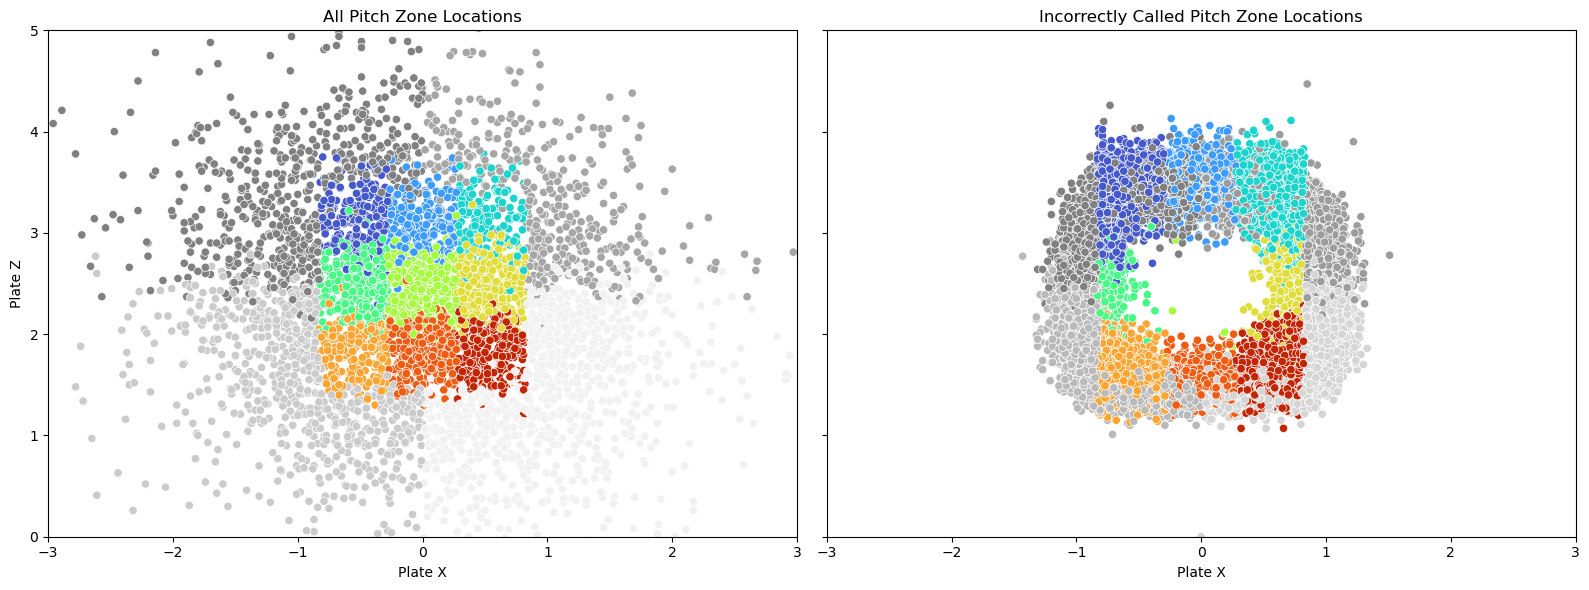

In [8]:
#| code-fold: true
#| code-summary: "Code for plotting strike zones"

import seaborn as sns
import matplotlib.pyplot as plt

# Just use 5000 pitches for clarity in the plot
subset = pitches.head(5000)

inside_zones = list(range(1, 10))
outside_zones_subset = sorted(subset[~subset["zone"].isin(inside_zones)]["zone"].unique())

rainbow_palette = sns.color_palette("turbo", n_colors=len(inside_zones))
gray_palette_subset = sns.light_palette("gray", n_colors=len(outside_zones_subset), reverse=True)

zone_colors_subset = {zone: color for zone, color in zip(inside_zones, rainbow_palette)}
zone_colors_subset.update({zone: color for zone, color in zip(outside_zones_subset, gray_palette_subset)})

# Incorrect pitches
incorrect_pitches = pitches_not_hit[pitches_not_hit["called_correctly"] == 0]
outside_zones_incorrect = sorted(incorrect_pitches[~incorrect_pitches["zone"].isin(inside_zones)]["zone"].unique())
gray_palette_incorrect = sns.light_palette("gray", n_colors=len(outside_zones_incorrect), reverse=True)

zone_colors_incorrect = {zone: color for zone, color in zip(inside_zones, rainbow_palette)}
zone_colors_incorrect.update({zone: color for zone, color in zip(outside_zones_incorrect, gray_palette_incorrect)})

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)

# Plot 1: All pitches
sns.scatterplot(
    data=subset,
    x="plate_x",
    y="plate_z",
    hue="zone",
    palette=zone_colors_subset,
    legend=False,
    ax=axes[0]
)
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(0, 5)
axes[0].set_title("All Pitch Zone Locations")
axes[0].set_xlabel("Plate X")
axes[0].set_ylabel("Plate Z")

# Plot 2: Incorrect pitches
sns.scatterplot(
    data=incorrect_pitches,
    x="plate_x",
    y="plate_z",
    hue="zone",
    palette=zone_colors_incorrect,
    legend=False,
    ax=axes[1]
)
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(0, 5)
axes[1].set_title("Incorrectly Called Pitch Zone Locations")
axes[1].set_xlabel("Plate X")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


#### Our Approach

We thought about using features in a few different ways, as we began with two large datasets, one about the information of the specific pitch, which included its speed, release information and landing information. We also had a dataset with player information that we merged. We created our target variable: weather the umpires call (strike or ball) matched the physical location of the pitch (strike or ball). Subsequently, we had to subset our data by only pitches that were not hit. We also downsampled our data to even out the number of pitches called correctly and incorrectly.  

We started off by including all variables, but realized this made the model too good- there were combinations of features that would give the model an almost direct indication of the status of the target variable. For example, when the count was full, the pitch was a ball and the chance of the batting team scoring a run increased, the model learned that 100% of the time, that pitch was called correctly (the umpire also called it a ball). In order to deal with this, we limited the features to only the ones that didn't give any indication as to where the pitch ended up.  

This made our model perform decently well, around 60-70% accuracy, but we quickly realized that the model was only accurate when predicting missed calls for pitches that were balls and and bad for pitches that were strikes.   

Thinking about this, we realized that there are a ton of pitches in our dataset that no matter the game situation or umpire bias wil be called correctly. These are pitches straight down the middle or pitches way outside of the zone. Realizing this, we subset out data to only include pitches within two inches on either side of the strike zone. This narrows down our analysis to only pitches that umpires might call wrong with a higher probability. 

Our analysis focused on evaluating the accuracy of umpire calls using two logistic regression models: a standard Scikit-Learn Logistic Regression model and a Custom Logistic Regression with Newton's Method. The primary features used as predictors included key pitch characteristics such as type, velocity, and horizontal and vertical position at the plate, along with batter attributes like handedness (left or right), and game context including pitch count, inning, and game situation; importantly, in the first iterations of the models information surrounding where the pitch ended up around the plate was excluded and was later added back in for pitches close to the edge of the strike zone. The target variable for prediction was whether the umpire’s call was correct, represented as a binary outcome (correct or incorrect).

Both models were trained separately, with the Scikit-Learn model serving as a baseline comparison and the custom Newton-based model leveraging second-order optimization for potentially faster and more efficient parameter updates. Model evaluation was conducted using key metrics such as Accuracy, False Positive Rate (FPR), and False Negative Rate (FNR). Additionally, confusion matrices were generated for visual inspection of model performance across subgroups, and the predictions were benchmarked against actual umpire accuracy to identify significant deviations or biases in decision-making.

### Results
The Scikit-Learn model showed a higher overall accuracy compared to the Custom Newton model. However, the Custom Newton model exhibited more stable convergence during training and demonstrated competitive performance in edge cases near the strike zone. The Scikit-Learn model struggled with overfitting to specific pitch types, particularly balls however the Newton struggled to converge on the data. Perhaps with more computing to run many more iterations of our Newton descent it could have converged; the Newton did however demonstrated much better generalizability to both balls and strikes as well as left vs right handed batters. Confusion matrices were generated for left-handed and right-handed batters, revealing that both models performed better for right-handed batters, with fewer false positives and a clearer decision boundary compared to left batters.

Confusion matrices were generated for left-handed and right-handed batters, highlighting key differences in model performance. Both models demonstrated improved accuracy for right-handed batters, with fewer false positives and a clearer decision boundary. This may suggest that the models are better calibrated for right-handed batting patterns or that there is an inherent bias in pitch tracking systems that favors right-handed batters. Conversely, left-handed batters experienced slightly higher error rates, particularly around borderline pitch locations. This discrepancy underlines the need for model adjustments to account for variability introduced by left-handed batting stances.

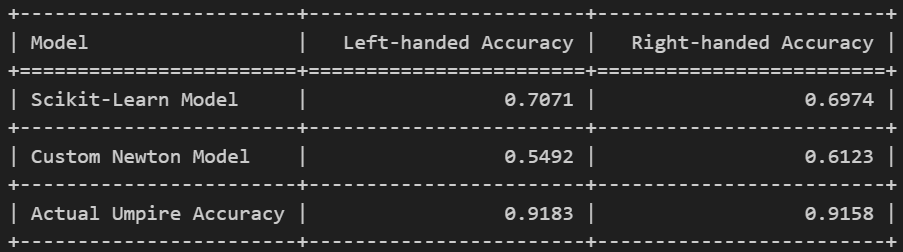

Interestingly, the Custom Newton model consistently predicted umpires to always make the incorrect call for both handedness groups and for balls versus strikes. While this resulted in more balanced predictive power across these categories, it did not necessarily translate into higher accuracy. Given more computational resources, it is plausible that additional iterations of the Newton descent could have achieved better convergence and accuracy and removed this trend.

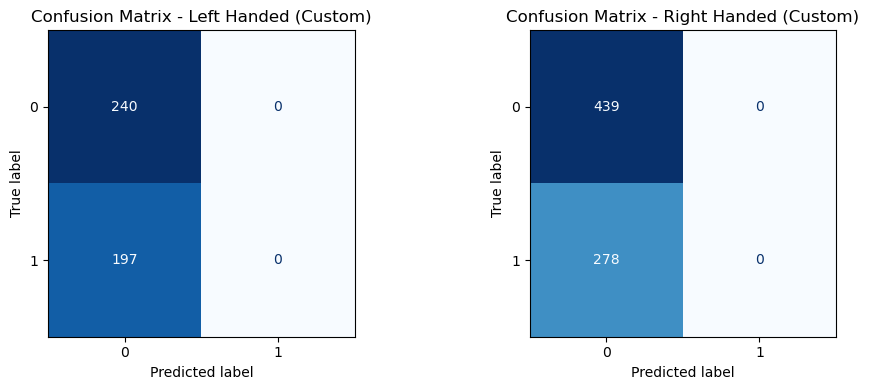

Further analysis focused on balls and strikes separately, revealing distinct behavioral patterns for each model. The Scikit-Learn model generally showed stronger stability across a broader range of pitch types and batter handedness. Its higher False Positive Rate (FPR) and False Negative Rate (FNR) scores were indicative of more conservative decision-making, particularly for borderline calls. This conservatism led to highly consistent identification of balls but resulted in nearly always missing whether or not the umpire made the correct call for strikes.

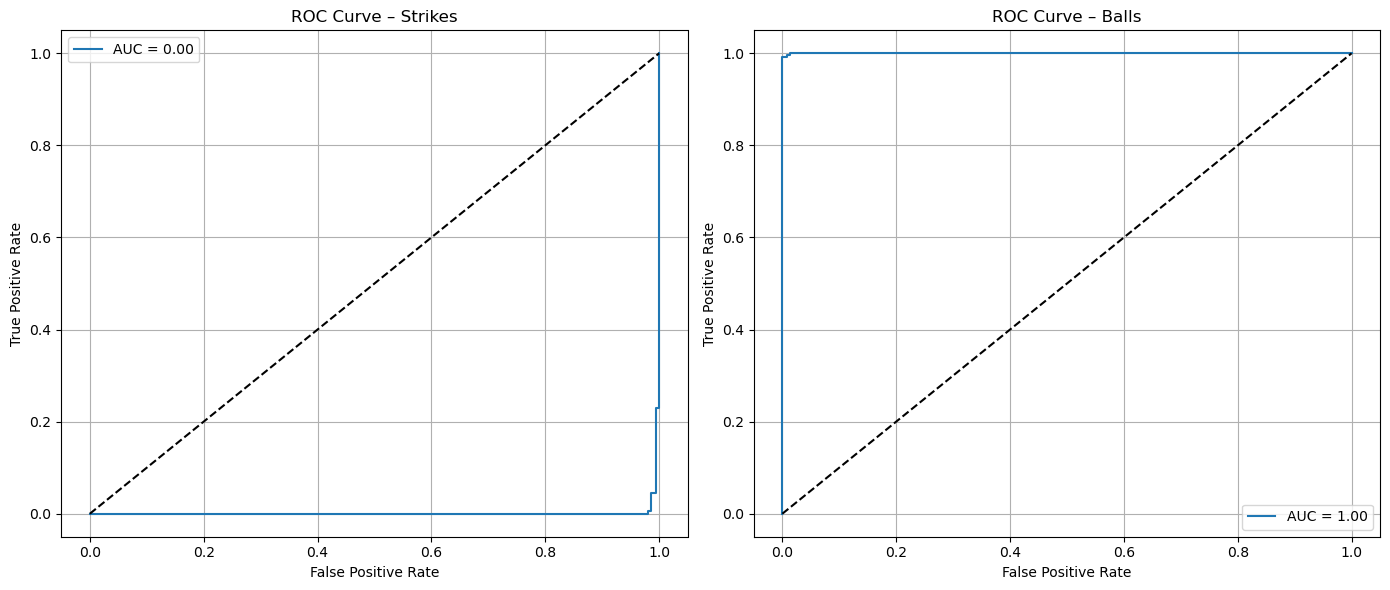

On the other hand, the Custom Newton model demonstrated slightly higher sensitivity when classifying strikes. This is likely due to the error in how the Newton model was predicting umpire calls. This error lead to increased false positives and much of the predictive power from the Newton model should be disregarded, espeically due to false convergence. 

The inability of the Custom Newton model to fully converge may be attributed to a combination of factors: dataset size, limited computational power, or an absence of clear patterns within the data. With further optimization and computational resources, Newton-based optimization could potentially achieve more accurate predictions, especially for classifications whithin specific regions such as handedness and edge-zone strikes.

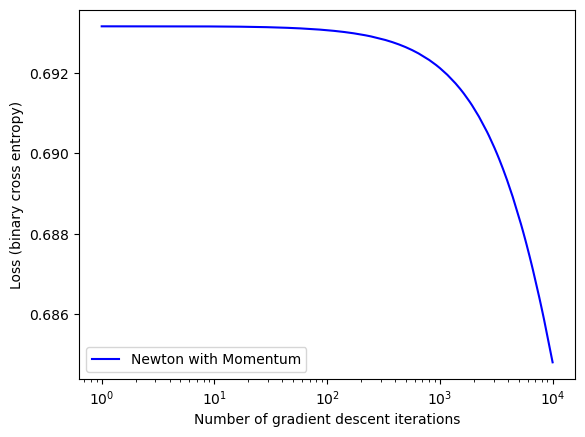

### Concluding Discussion

Our project was successful in that we were able to use a model that worked to predict our target variable. Specifically, we were able to predict with reasonable accuracy whether a ball would be called incorrectly. But, we also had some failures in our project, like the failure of our custom model to converge. We found some interesting results in our audit for bias, for example differences in model accuracy between right- and left-handed batters. We felt that we met the goals that we set at the beginning of the project. We were successful in creating a model and finding some interesting results. Compared some of the other work in this area, we found results along the lines of what we expected. The features that we found to be most important aligned with some of the papers that we read in preparation for the project, like pitch count. We didn't see anyone look at model performance across batter-handedness, so this was a particularly interesting result. If we had more time to work on the project, we would have two main priorities. First, we'd want to further investigate the discrepancy between model performance for balls and strikes. We discussed a few hypotheses about why we thought this difference occurred, but we'd want to further investigate the features we are using in our model to see if any of them were overly correlated to our target variable or where the pitch ended up relative to the strike zone over the plate. We would also want to continue working with our custom model to see if we could get it to converge. Although the issues with convergence could be attributed to lack of patterns in the data, with more tuning of parameters and the features we train our model on, we may have been able to see a better performance from the model. 

### Group Contributions Statement

Our group spent a lot of time working in person together on the project, so we all contributed to each part of the source code. But, in general, each person contributed the most to a file with their name on it. Carly did all of the data pulling, data cleaning, outside research, and initial visualizations. Chloe worked on figuring out which features we should train our model on and initial evaluation of which features were most important. Ryan took the lead on the custom LR model and auditing for bias. We all worked on creating this blog post. Carly wrote the introduction, data explanation, values statement, and strike zone visualizations. Chloe worked on documenting our process, specifically how we subsetted the data and how we chose our features. Ryan worked on explaining our models and the results from our auditing. Overall, we all felt that we contributed equally to the project and we each took the lead on different parts of the project. 


### Personal Reflection
What ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍did ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍you ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍learn ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍process ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍researching, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍implementing, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍communicating ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍about ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍your ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍project?  
First off, I learned that umpires are actually really good at their jobs! This was also a project that I felt like I was able to apply a lot of what I have learned in other comp sci classes and various projects to this, so it felt really cool to have this sort of capstone at the end of my academic computer science carreer. Our team had really great internal communication, but I think one of the most valuable lessons was the external communication nescessary to explain our poject and updates to classmates in our check ins. I defintley improved on this over time, and figuring out how to explain what I spent hours on in a few minutes was a very helpful excersize that made me realize what the main points of my analysis was.  
How ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍do ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍you ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍feel ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍about ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍what ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍you ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍achieved? ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Did ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍meet ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍your ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍initial ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍goals? ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍Did ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍you ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍exceed ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍them ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍or ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍fall ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍short? ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍In ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍what ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍ways?  
I am very happy about what we achieved. Initially, we knew we wanted to look at umpire bias, but we didn't know where to start. Baseball is a famously data driven industry, and the fact that we were able to utilize all of this data in a concise way was really exciting. We achieved our inital goal of detecting bias, as we found differences between right and left handed batters. I think we exceeded them, as filtering and analyzing the dataset required a lot more analysis than itally thought.  
In ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍what ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍ways ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍will ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍you ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍carry ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍experience ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍working ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍this ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍project ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍into ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍your ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍next ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍courses, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍career ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍stages, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍or ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍personal ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍life?  
This project gave me a lot of insight into stepping stone progress and teamwork. While I don't know the next time I'll be coding in python this intensely, I do know that my job will require a lot of teamwork and communication, which this class and project specifically has well prepared me for. Learning how to deal with hiccups and effectivley communicate my ideas will be very important.